In [1]:
import sys
assert sys.version_info >= (3, 6), "This script requires Python 3.6 or higher."

import sklearn
assert sklearn.__version__ >= "0.24", "This script requires scikit-learn version 0.24 or higher."

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

### MNIST

**Warning**: `fech_openml()` returns Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
28 * 28

784

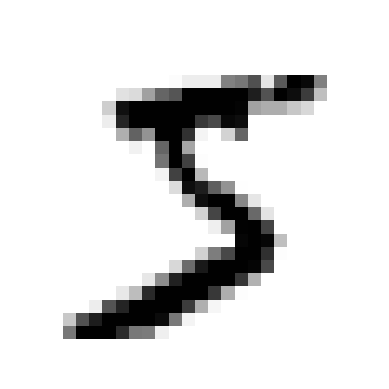

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")

plt.show()

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)  # Convert labels to uint8 for consistency

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [9]:
# EXTRA

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    n_rows = (len(instances) - 1) // images_per_row + 1
    image = np.zeros((n_rows * size, images_per_row * size), dtype=np.uint8)
    for index, instance in enumerate(instances):
        row = index // images_per_row
        col = index % images_per_row
        image[row * size:(row + 1) * size, col * size:(col + 1) * size] = instance.reshape(size, size)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

In [10]:
def plot_digits2(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = cell(len(instances) / images_per_row) + 1
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if Needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28x28 images:
    images_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical images axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we can reshape:
    big_image = images_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

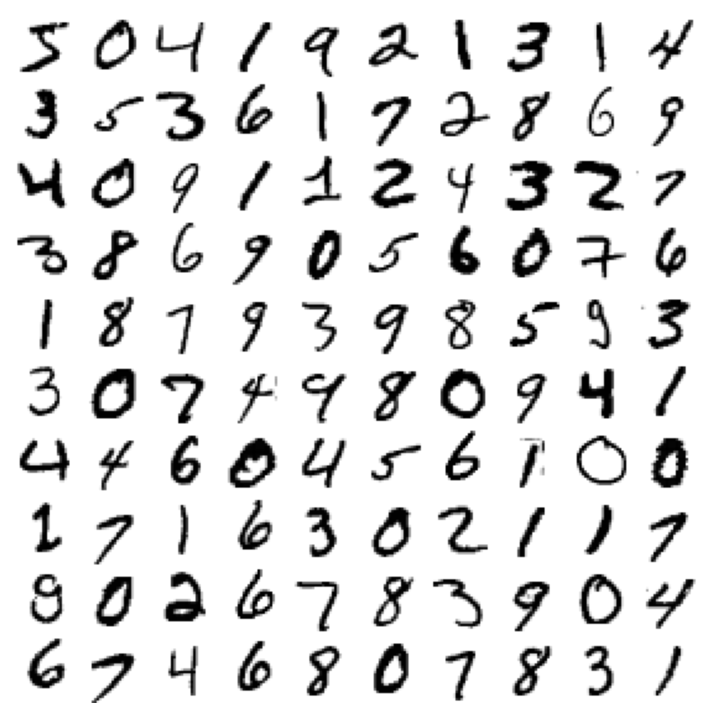

In [11]:
plt.figure(figsize=(9, 9))
example_iamges = X[:100]
plot_digits(example_iamges, images_per_row=10)
plt.show()

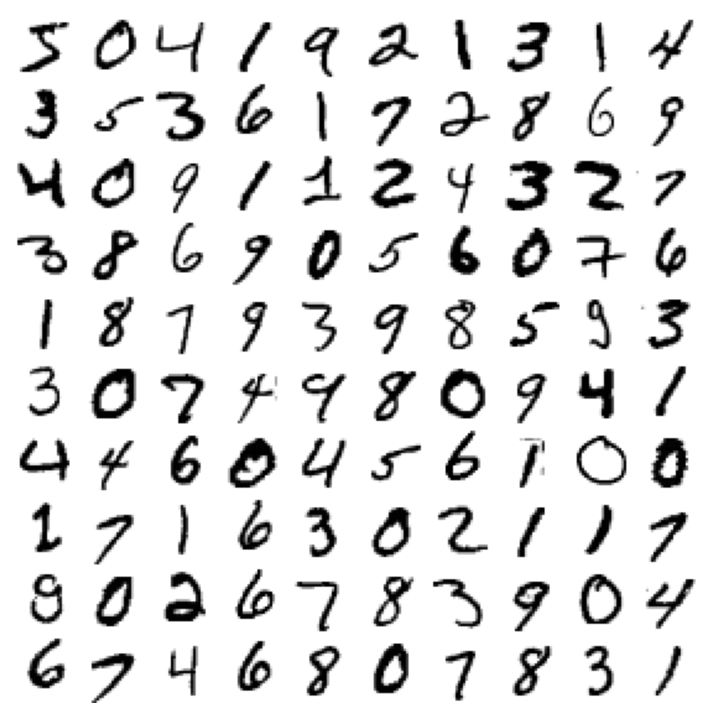

In [12]:
plt.figure(figsize=(9, 9))
example_iamges = X[:100]
plot_digits2(example_iamges, images_per_row=10)
plt.show()

In [13]:
y[0]

np.uint8(5)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

Contoh **binary classifier** yang mampu membedakan antara 2 kelas 5 dan bukan 5, Create target vector for this classification task:

In [15]:
y_train_5 = (y_train == 5)      # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Memulai dengan **Stochastic Gradient Descent (SGD)** classifier ini memiliki keuntungan mampu menangani dataset besar dengan efisien karena menangani sebagian.

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**SGDClassifier** bergantung pada keacakan selama pelatihan oleh karena iu namya "stochastic", jika ingin hasilnya direproduksi harus mengatus **random_state** parameter

In [17]:
# Deteksi gambar number 5
sgd_clf.predict([some_digit])

array([ True])

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

In [29]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [30]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(0.7325171197343847)

#### Precision / Recall Trade-off

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(threshold, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(threshold, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

In [37]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

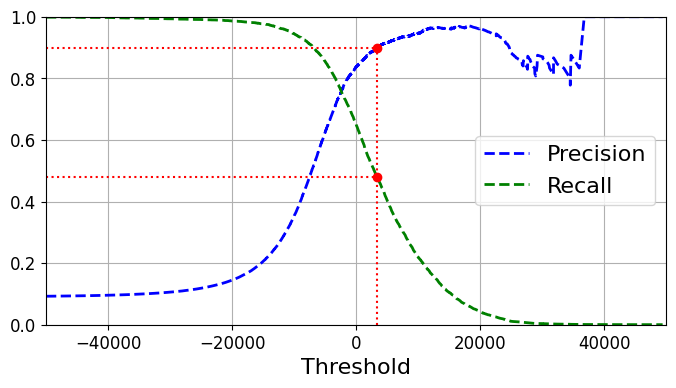

In [38]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [39]:
(y_train_pred == (y_scores > 0)).all()

np.True_

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

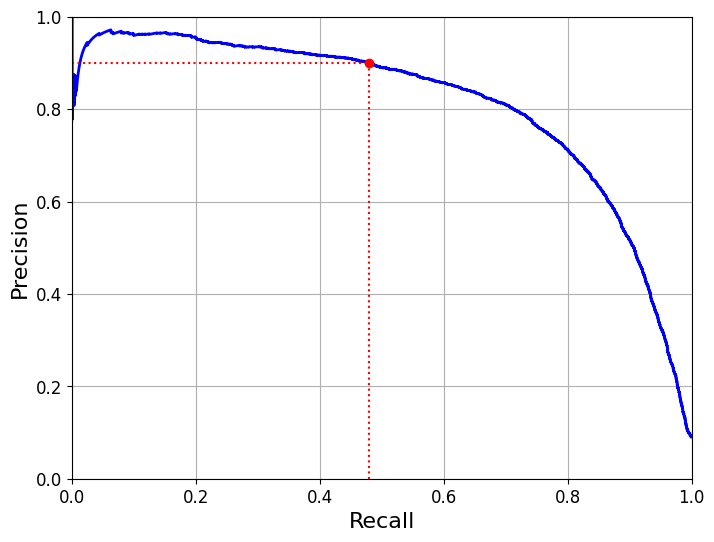

In [41]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

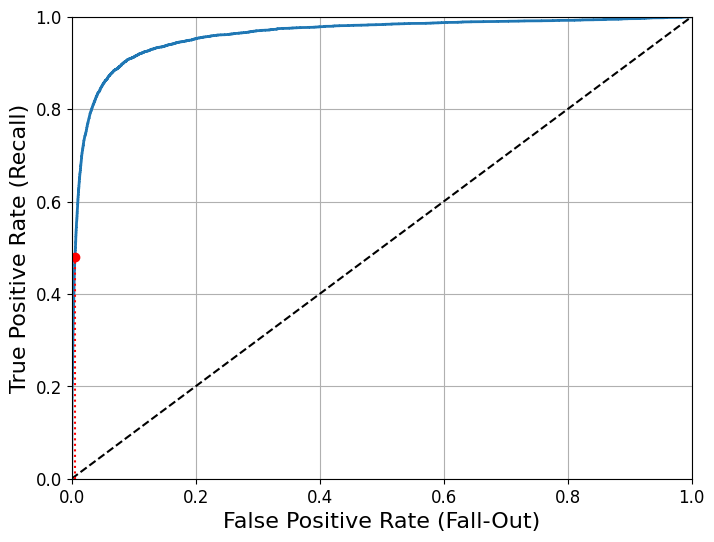

In [47]:
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                   # Not shown
plt.show()

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

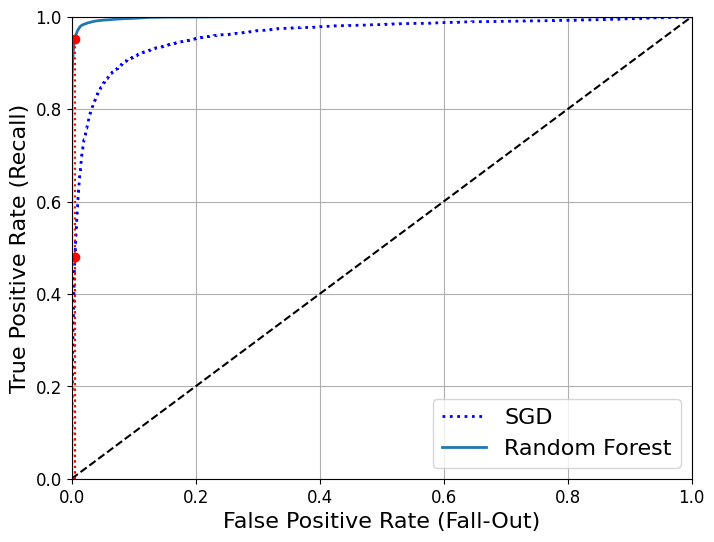

In [51]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [57]:
np.argmax(some_digit_scores)

np.int64(5)

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

np.uint8(5)

In [60]:
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

45

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5570,    0,   15,    3,    9,   39,   33,    5,  248,    1],
       [   0, 6408,   41,   21,    3,   41,    4,    7,  208,    9],
       [  26,   25, 5220,   85,   67,   24,   62,   37,  401,   11],
       [  26,   18,  107, 5187,    0,  184,   24,   39,  483,   63],
       [  10,   13,   36,    9, 5183,   10,   34,   20,  381,  146],
       [  26,   18,   23,  155,   51, 4401,   77,   13,  596,   61],
       [  26,   17,   41,    2,   40,   83, 5548,    7,  154,    0],
       [  20,   11,   52,   23,   48,   11,    3, 5685,  217,  195],
       [  16,   58,   37,   88,    2,  119,   28,    8, 5459,   36],
       [  21,   19,   28,   58,  119,   30,    1,  170,  429, 5074]])

In [67]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

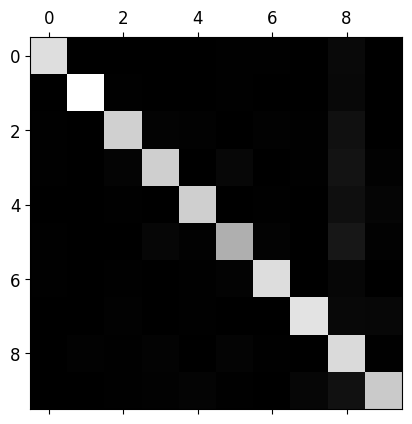

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

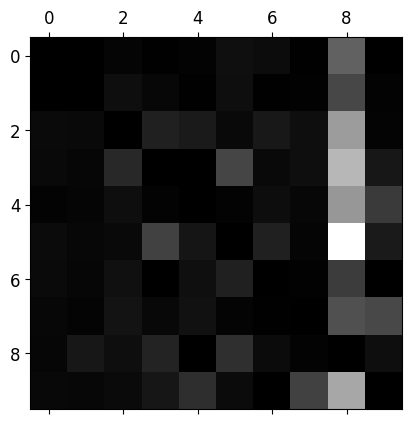

In [70]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

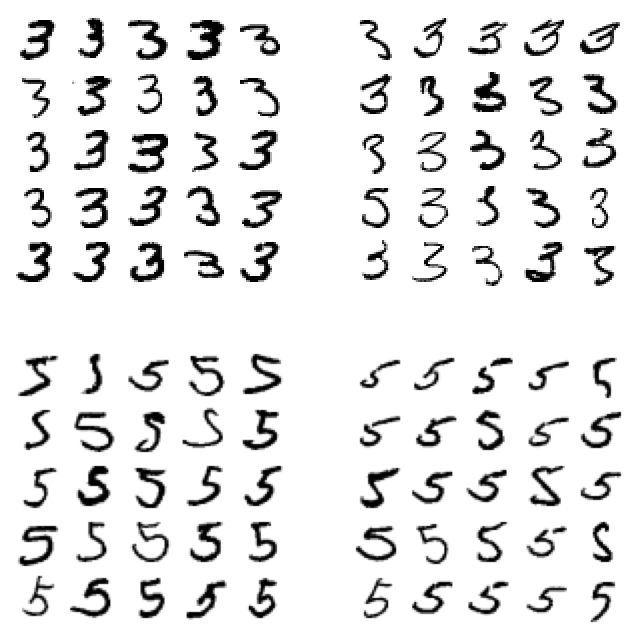

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

### Multilabel Classification

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

### Multioutput Classification

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

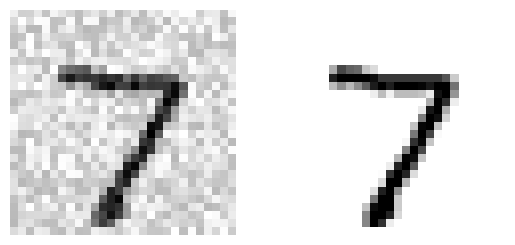

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

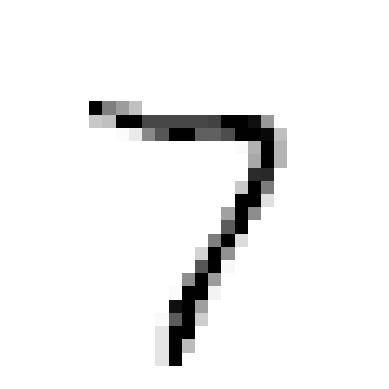

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### Extra material
#### Dummy (ie. random) classifier

In [78]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

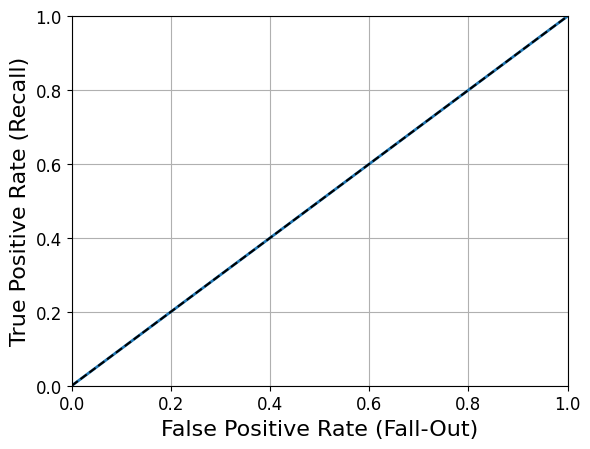

In [79]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
y_knn_pred = knn_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14136\3518175631.py:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


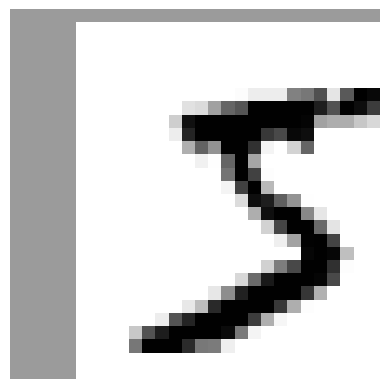

In [83]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [84]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [85]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [86]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [87]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

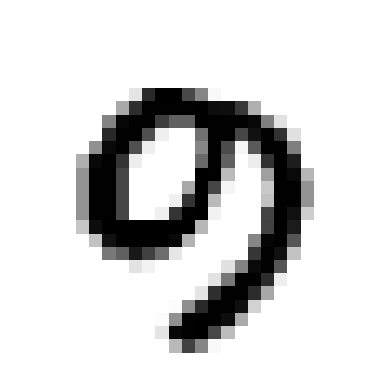

In [89]:
plot_digit(ambiguous_digit)

1. Build classifier for MNIST dataset over 97% accuracy

In [91]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier()

# param_grid = {
#     'n_neighbors' : np.arange(1, 11),
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'p': [1, 2]
# }

# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# grid.fit(X_train, y_train)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  18.9s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  14.0s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  12.5s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  12.6s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  12.5s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  11.9s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  11.9s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  11.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  12.8s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [21]:
# Print the best hyperparameters and corresponding accuracy

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 4, 'weights': 'distance'}
Best Accuracy: 0.9716166666666666


In [22]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

#### 2. Data Augmentation

In [19]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2560\97103598.py:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


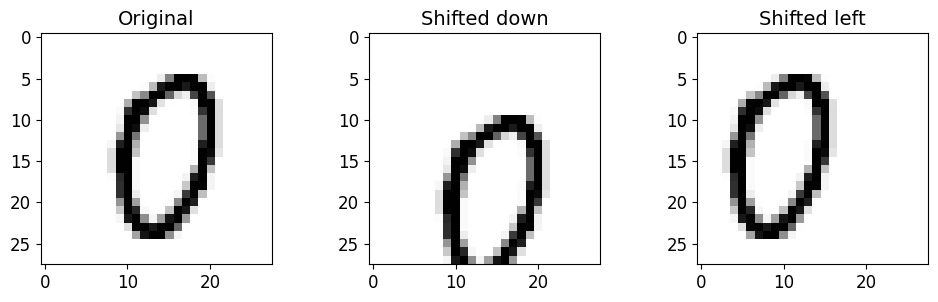

In [20]:
import matplotlib.pyplot as plt

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [23]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [24]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [25]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

### 3. Tackle the Titanic dataset

The goal is to predict whether or not a pessenger survived based on attributes such as their age, sex, pessenger, calss where they embarked and so on.

Let's fetch the data and load it:

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Datanya sudah dibagi menjadi data training dan testing, tetapi data test tidak memiliki label sehingga tujuan dari ini melatih model menggunakan training data untuk membuat prediksi data test

In [4]:
# melihat 10 data pertama data training

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Atribut data terdiri dari:
* `PassengerId`: a unique identifier for each passenger
* `Survived`: that's the target, 0 means the pessenger did not survive, while 1 means he/she survived.
* `Pclass`: passenger class.
* `Name`, `Sex`, `Age`: self-explanatory
* `SipSp`: how many siblings & the passenger aboard the Titanic.
* `Parch`: how many children & parents of the passanger aboard the Titanic.
* `Ticket`: ticket_id
* `Cabin`: passeger's cabin number
* `Embarked`: where the embarked the Titanc

In [5]:
# Let's explicitly set the PessengerId column as the index column:

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [6]:
# Check Missing data

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [14]:
train_data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [13]:
(train_data.isnull().sum() / len(train_data)).round(4)

Survived    0.0000
Pclass      0.0000
Name        0.0000
Sex         0.0000
Age         0.1987
SibSp       0.0000
Parch       0.0000
Ticket      0.0000
Fare        0.0000
Cabin       0.7710
Embarked    0.0022
dtype: float64

In [7]:
train_data[train_data["Sex"] == "female"]["Age"].median()

np.float64(27.0)

Jadi, `Age`, `Cabin` dan `Embarked` berisi attribute null (harusnya 891) khususnya `Cabin` (77% null). Kita akan mengabaikan `Cabin` dan fokus ke rest. Kemudian untuk Age (17% null) mengganti null value dengan median age

In [15]:
# Melihat numberical attribute:

train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Rata-rata yang selamat 38%
* Mean age kurang dari 30 tahun
* 

In [16]:
# Check target Survived

train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [18]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [19]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [20]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute:
C = Cherbourg
Q = Queenstown
S = Southampton

In [26]:
# Pipeline for numberical attributes

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [27]:
# Pipeline for categorical attributes

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False)),
])

In [28]:
# Gabungkan numberical dan categorical

from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Preprocessing raw data ke output numberical 

In [30]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs]
)

X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [31]:
# Initial label

y_train = train_data["Survived"]

In [32]:
# Menggunakan random forest classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Make prediction data test

X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [34]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8137578027465668)

In [35]:
# Ayo ganti ke SVC

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18256\2324622529.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))


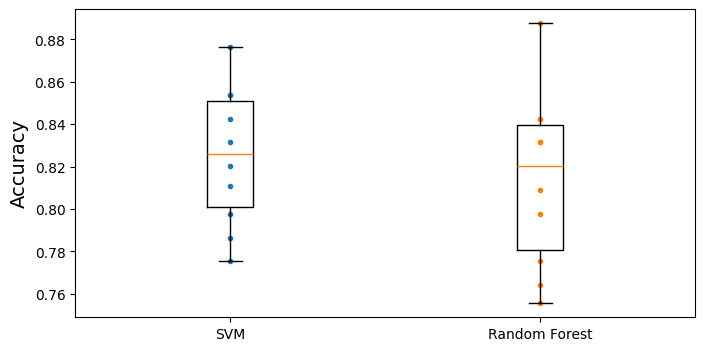

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [37]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [38]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


#### 4. Build Spam Classifier

In [1]:
# Download data spam and ham from public datasets

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tz.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham_2.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam_2.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):

    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)

    for filename, url in (("ham_2.tar.bz2", ham_url), ("spam_2.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

In [3]:
# Load data all emails

HAM_DIR = os.path.join(SPAM_PATH, "easy_ham_2")
SPAM_DIR = os.path.join(SPAM_PATH, "spam_2")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
len(ham_filenames)

1400

In [5]:
len(spam_filenames)

1397

In [6]:
# Menggunakan library python email untuk mengurai emal

import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam_2" if is_spam else "easy_ham_2"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [8]:
# Coba lihat contoh ham dan spam

print(ham_emails[1])

Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id DE7E443C32
	for <jm@localhost>; Wed, 21 Aug 2002 11:18:34 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 21 Aug 2002 16:18:34 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org
 [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
 g7LFFwZ30827 for    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 16:16:07 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain
 [127.0.0.1]) by    listman.redhat.com (Postfix) with ESMTP id 78A9B405D2;
 Wed, 21 Aug 2002    11:16:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp.spamassassin.taint.org
 (int-mx1.corp.spamassassin.taint.org    [172.16.52.254

In [9]:
print(spam_emails[6])

Return-Path: sales@outsrc-em.com
Delivery-Date: Thu Jun 20 20:08:33 2002
Received: from outsrc-em.com ([166.70.149.104]) by dogma.slashnull.org
    (8.11.6/8.11.6) with SMTP id g5KJ8WI08701 for <jm@jmason.org>;
    Thu, 20 Jun 2002 20:08:32 +0100
Message-Id: <200206201908.g5KJ8WI08701@dogma.slashnull.org>
From: "Outsource Sales" <sales@outsrc-em.com>
To: "yyyy@spamassassin.taint.org" <yyyy@spamassassin.taint.org>
Subject: New Product Announcement
Sender: "Outsource Sales" <sales@outsrc-em.com>
MIME-Version: 1.0
Content-Type: text/plain; charset="ISO-8859-1"
Date: Fri, 3 Jan 1997 17:24:47 -0700
Reply-To: "Outsource Sales" <sales@outsrc-em.com>
Content-Transfer-Encoding: 8bit
X-Keywords: 

NEW PRODUCT ANNOUNCEMENT

From: OUTSOURCE ENG.& MFG. INC.


Sir/Madam;

This note is to inform you of new watchdog board technology for maintaining
continuous unattended operation of PC/Servers etc. that we have released for
distribution.
  
We are proud to announce Watchdog Control Center featuring MA

Beberapa email kenyataanya multipart, dengan gambar dan attachments, jadi lihat beberapa type struktur yang ada:

In [10]:
def get_email_structure(email):

    if isinstance(email, str):
        return email

    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email) for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()

    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structures_counter(ham_emails).most_common()

[('text/plain', 1343),
 ('multipart(text/plain, application/pgp-signature)', 35),
 ('multipart(text/plain, text/html)', 12),
 ('text/html', 2),
 ('multipart(text/plain, application/x-patch)', 1),
 ('multipart(multipart(text/plain, multipart(text/plain), text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/gif, image/gif, image/gif, image/gif)',
  1),
 ('multipart(text/plain, application/ms-tnef)', 1),
 ('multipart(text/plain, text/plain, text/plain)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 598),
 ('text/html', 589),
 ('multipart(text/plain, text/html)', 114),
 ('multipart(text/html)', 29),
 ('multipart(text/plain)', 25),
 ('multipart(multipart(text/html))', 18),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/html, text/plain)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/gif)',
  1),
 ('text/plain charset=us-ascii', 1),
 ('multipart(multipart(text/html), image/gif)', 1),
 ('multipart(multipart(text/plain, text/html), application/octet-stream, application/octet-stream, applic

Untuk ham email lebih sering plain text

In [14]:
# Check email header

for header, value, in spam_emails[1].items():
    print(header, ':', value)

Return-Path : merchantsworld2001@juno.com
Delivery-Date : Mon May 13 04:46:13 2002
Received : from mandark.labs.netnoteinc.com ([213.105.180.140]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4D3kCe15097 for    <jm@jmason.org>; Mon, 13 May 2002 04:46:12 +0100
Received : from 203.129.205.5.205.129.203.in-addr.arpa ([203.129.205.5]) by    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with SMTP id g4D3k2D12605 for    <jm@netnoteinc.com>; Mon, 13 May 2002 04:46:04 +0100
Received : from html (unverified [207.95.174.49]) by    203.129.205.5.205.129.203.in-addr.arpa (EMWAC SMTPRS 0.83) with SMTP id    <B0000178595@203.129.205.5.205.129.203.in-addr.arpa>; Mon, 13 May 2002    09:04:46 +0530
Message-Id : <B0000178595@203.129.205.5.205.129.203.in-addr.arpa>
From : lmrn@mailexcite.com
To : ranmoore@cybertime.net
Subject : Real Protection, Stun Guns!  Free Shipping! Time:2:01:35 PM
Date : Mon, 28 Jul 1980 14:01:35 -0000
MIME-Version : 1.0
X-Keywords : 
Content-Type : text/html; charset="D

There's probably a lot of useful information in there, such as the sender's email address (lmrn@mailexcite.com looks fishy), but we will just focus on the `Subject` header:

In [15]:
spam_emails[1]["Subject"]

'Real Protection, Stun Guns!  Free Shipping! Time:2:01:35 PM'

In [16]:
# Split data to training and tesing data

import numpy as np

from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [17]:
import re

from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [18]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [20]:
# And hasil dari plain text

print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [ ]:
# Make function menggambil email input dan mengembalikan content as plain text apapun formatnya

def email_to_text(email):
    html = None

    for part in email.walk():
        ctype = part.get_content_type()

        if not ctype in ("text/plain", "text/html"):
            continue

        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())

        if ctype == "text/plain":
            return content
        else:
            html = content

    if html:
        return html_to_plain_text(html)

In [23]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [24]:
# Make stemming text

try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [25]:
try:
    import urlextract

    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailTowardCounterTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []

        for email in X:
            text = email_to_text(email) or ""

            if self.lower_case:
                text = text.lower()

            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")

            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)

            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)

            word_counts = Counter(text.split())

            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()

                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count

                word_counts = stemmed_word_counts

            X_transformed.append(word_counts)

        return np.array(X_transformed)

In [27]:
# Check transformer on a few emails

X_few = X_train[:3]
X_few_wordcounts = EmailTowardCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'s': 5, 'number': 5, 'of': 5, 'stabl': 5, 'is': 5, 'that': 5, 'a': 4, 'it': 4, 'for': 4, 'be': 4, 'ie': 3, 'the': 3, 'ipfwnumb': 3, 'been': 3, 'roll': 3, 'into': 3, 'linux': 3, 'nick': 2, 'list': 2, 'releas': 2, 'ipfilt': 2, 'are': 2, 'inde': 2, 'ha': 2, 'out': 2, 'major': 2, 'in': 2, 'i': 2, 'not': 2, 'readi': 2, 'product': 2, 'some': 2, 'and': 2, 'ipfw': 2, 'there': 2, 'url': 2, 'hilliard': 1, 'netabl': 1, 'line': 1, 'wisdom': 1, 'includ': 1, 'standard': 1, 'version': 1, 'unencumb': 1, 'as': 1, 'alway': 1, 'nope': 1, 'just': 1, 'branch': 1, 'code': 1, 'current': 1, 'first': 1, 'basic': 1, 'still': 1, 'work': 1, 'progress': 1, 'm': 1, 'so': 1, 'sure': 1, 'realli': 1, 'yet': 1, 'have': 1, 'onli': 1, 'mfc': 1, 'd': 1, 'last': 1, 'wednesday': 1, 'certainli': 1, 'add': 1, 'nice': 1, 'syntact': 1, 'sugar': 1, 'appar': 1, 'much': 1, 'faster': 1, 'certain': 1, 'type': 1, 'complex': 1, 'ruleset': 1, 'will': 1, 'good': 1, 'onc': 1, 'had': 1, 'time': 1, 'to': 1, 'settl': 1, 'dow

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, vocabulary_size = 1000):
        self.vocabulary_size = vocabulary_size

    def fit(self, X, y=None):
        total_count = Counter()

        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)

        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}

        return self

    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []

        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)

        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [29]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 31 stored elements in Compressed Sparse Row format>

In [30]:
X_few_vectors.toarray()

array([[ 165,    5,    3,    4,    1,    5,    5,    0,    0,    4,    1],
       [ 784,   62,   31,    9,   31,   15,   11,   16,   16,   17,    9],
       [1752,  195,    9,    8,   12,    5,    5,   17,   10,    5,    7]])

What does this matrix mean? Well, the 784 in the second row, first column, means that the second email contains 62 words that are not part of the vocabulary. The 62 next to it means that the first word in the vocabulary is present 62 times in this email. The 31 next to it means that the second word is present 31 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [31]:
vocab_transformer.vocabulary_

{'number': 1,
 'the': 2,
 'a': 3,
 'to': 4,
 'of': 5,
 'is': 6,
 'your': 7,
 'you': 8,
 'for': 9,
 'will': 10}

In [32]:
# Make preprocessing to transofrom dataset

from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailTowardCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.983) total time=   0.1s
[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.979) total time=   0.1s


np.float64(0.977202199950819)

In [34]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 97.80%
Recall: 98.16%
